In [96]:
import pickle
import numpy as np
from numpy import genfromtxt
from collections import defaultdict
import pandas as pd
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import csv
import re
import tabulate


def load_data():
    item_train = genfromtxt('./sample_data/content_item_train.csv', delimiter=',')
    user_train = genfromtxt('./sample_data/content_user_train.csv', delimiter=',')
    y_train    = genfromtxt('./sample_data/content_y_train.csv', delimiter=',')
    with open('./sample_data/content_item_train_header.txt', newline='') as f:    #csv reader handles quoted strings better
        item_features = list(csv.reader(f))[0]
    with open('./sample_data/content_user_train_header.txt', newline='') as f:
        user_features = list(csv.reader(f))[0]
    item_vecs = genfromtxt('./sample_data/content_item_vecs.csv', delimiter=',')

    movie_dict = defaultdict(dict)
    count = 0
#    with open('./data/movies.csv', newline='') as csvfile:
    with open('./sample_data/content_movie_list.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in reader:
            if count == 0:
                count +=1  #skip header
                #print(line)
            else:
                count +=1
                movie_id = int(line[0])
                movie_dict[movie_id]["title"] = line[1]
                movie_dict[movie_id]["genres"] =line[2]

    with open('./sample_data/content_user_to_genre.pickle', 'rb') as f:
        user_to_genre = pickle.load(f)

    return (item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre)


def pprint_train(x_train, features,  vs, u_s, maxcount = 5, user=True):
    """ Prints user_train or item_train nicely """
    if user:
        flist = [".0f",".0f",".1f",
                 ".1f", ".1f", ".1f", ".1f",".1f",".1f", ".1f",".1f",".1f", ".1f",".1f",".1f",".1f",".1f"]
    else:
        flist = [".0f",".0f",".1f",
                 ".0f",".0f",".0f", ".0f",".0f",".0f", ".0f",".0f",".0f", ".0f",".0f",".0f",".0f",".0f"]

    head = features[:vs]
    if vs < u_s: print("error, vector start {vs} should be greater then user start {u_s}")
    for i in range(u_s):
        head[i] = "[" + head[i] + "]"
    genres = features[vs:]
    hdr = head + genres
    disp = [split_str(hdr, 5)]
    count = 0
    for i in range(0,x_train.shape[0]):
        if count == maxcount: break
        count += 1
        disp.append( [
                      x_train[i,0].astype(int),
                      x_train[i,1].astype(int),
                      x_train[i,2].astype(float),
                      *x_train[i,3:].astype(float)
                    ])
    table = tabulate.tabulate(disp, tablefmt='html',headers="firstrow", floatfmt=flist, numalign='center')
    return(table)


def pprint_data(y_p, user_train, item_train, printfull=False):
    np.set_printoptions(precision=1)

    for i in range(0,1000):
        #print(f"{y_p[i,0]: 0.2f}, {ynorm_train.numpy()[i].item(): 0.2f}")
        print(f"{y_pu[i,0]: 0.2f}, {y_train[i]: 0.2f}, ", end='')
        print(f"{user_train[i,0].astype(int):d}, ",  end='')   # userid
        print(f"{user_train[i,1].astype(int):d}, ", end=''),  #  rating cnt
        print(f"{user_train[i,2].astype(float): 0.2f}, ",  end='')       # rating ave
        print(": ", end = '')
        print(f"{item_train[i,0].astype(int):d}, ",  end='')   # movie id
        print(f"{item_train[i,2].astype(float):0.1f}, ", end='')   # ave movie rating
        if printfull:
          for j in range(8, user_train.shape[1]):
            print(f"{user_train[i,j].astype(float):0.1f}, ", end='')   # rating
          print(":", end='')
          for j in range(3, item_train.shape[1]):
            print(f"{item_train[i,j].astype(int):d}, ", end='')   # rating
          print()
        else:
          a = user_train[i, uvs:user_train.shape[1]]
          b = item_train[i, ivs:item_train.shape[1]]
          c = np.multiply(a,b)
          print(c)

def split_str(ifeatures, smax):
    ofeatures = []
    for s in ifeatures:
        if ' ' not in s:  # skip string that already have a space
            if len(s) > smax:
                mid = int(len(s)/2)
                s = s[:mid] + " " + s[mid:]
        ofeatures.append(s)
    return(ofeatures)

def pprint_data_tab(y_p, user_train, item_train, uvs, ivs, user_features, item_features, maxcount = 20, printfull=False):
    flist = [".1f", ".1f", ".0f", ".1f", ".0f", ".0f", ".0f",
             ".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f",".1f"]
    user_head = user_features[:uvs]
    genres = user_features[uvs:]
    item_head = item_features[:ivs]
    hdr = ["y_p", "y"] + user_head + item_head + genres
    disp = [split_str(hdr, 5)]
    count = 0
    for i in range(0,y_p.shape[0]):
        if count == maxcount: break
        count += 1
        a = user_train[i, uvs:user_train.shape[1]]
        b = item_train[i, ivs:item_train.shape[1]]
        c = np.multiply(a,b)

        disp.append( [ y_p[i,0], y_train[i],
                      user_train[i,0].astype(int),   # user id
                      user_train[i,1].astype(int),   # rating cnt
                      user_train[i,2].astype(float), # user rating ave
                      item_train[i,0].astype(int),   # movie id
                      item_train[i,1].astype(int),   # year
                      item_train[i,2].astype(float),  # ave movie rating
                      *c
                     ])
    table = tabulate.tabulate(disp, tablefmt='html',headers="firstrow", floatfmt=flist, numalign='center')
    return(table)




def print_pred_movies(y_p, user, item, movie_dict, maxcount=10):
    """ print results of prediction of a new user. inputs are expected to be in
        sorted order, unscaled. """
    count = 0
    movies_listed = defaultdict(int)
    disp = [["y_p", "movie id", "rating ave", "title", "genres"]]

    for i in range(0, y_p.shape[0]):
        if count == maxcount:
            break
        count += 1
        movie_id = item[i, 0].astype(int)
        if movie_id in movies_listed:
            continue
        movies_listed[movie_id] = 1
        disp.append([y_p[i, 0], item[i, 0].astype(int), item[i, 2].astype(float),
                    movie_dict[movie_id]['title'], movie_dict[movie_id]['genres']])

    table = tabulate.tabulate(disp, tablefmt='html',headers="firstrow")
    return(table)

def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1))
    return(user_vecs)

# predict on  everything, filter on print/use
def predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scaler, ScalerUser, ScalerItem, scaledata=False):
    """ given a user vector, does the prediction on all movies in item_vecs returns
        an array predictions sorted by predicted rating,
        arrays of user and item, sorted by predicted rating sorting index
    """
    if scaledata:
        scaled_user_vecs = ScalerUser.transform(user_vecs)
        scaled_item_vecs = ScalerItem.transform(item_vecs)
        y_p = model.predict([scaled_user_vecs[:, u_s:], scaled_item_vecs[:, i_s:]])
    else:
        y_p = model.predict([user_vecs[:, u_s:], item_vecs[:, i_s:]])
    y_pu = scaler.inverse_transform(y_p)

    if np.any(y_pu < 0) :
        print("Error, expected all positive predictions")
    sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
    sorted_ypu   = y_pu[sorted_index]
    sorted_items = item_vecs[sorted_index]
    sorted_user  = user_vecs[sorted_index]
    return(sorted_index, sorted_ypu, sorted_items, sorted_user)


def print_pred_debug(y_p, y, user, item, maxcount=10, onlyrating=False,  printfull=False):
    """ hopefully reusable print. Keep for debug """
    count = 0
    for i in range(0, y_p.shape[0]):
        if onlyrating == False or (onlyrating == True and y[i,0] != 0):
            if count == maxcount: break
            count += 1
            print(f"{y_p[i, 0]: 0.2f}, {y[i,0]: 0.2f}, ", end='')
            print(f"{user[i, 0].astype(int):d}, ",  end='')       # userid
            print(f"{user[i, 1].astype(int):d}, ", end=''),       #  rating cnt
            print(f"{user[i, 2].astype(float):0.1f}, ", end=''),       #  rating ave
            print(": ", end = '')
            print(f"{item[i, 0].astype(int):d}, ",  end='')       # movie id
            print(f"{item[i, 2].astype(float):0.1f}, ", end='')   # ave movie rating
            print(": ", end = '')
            if printfull:
                for j in range(uvs, user.shape[1]):
                    print(f"{user[i, j].astype(float):0.1f}, ", end='') # rating
                print(":", end='')
                for j in range(ivs, item.shape[1]):
                    print(f"{item[i, j].astype(int):d}, ", end='')    # rating
                print()
            else:
                a = user[i, uvs:user.shape[1]]
                b = item[i, ivs:item.shape[1]]
                c = np.multiply(a,b)
                print(c)


def get_user_vecs(user_id, user_train, item_vecs, user_to_genre):
    """ given a user_id, return:
        user train/predict matrix to match the size of item_vecs
        y vector with ratings for all rated movies and 0 for others of size item_vecs """

    if user_id not in user_to_genre:
        print("error: unknown user id")
        return(None)
    else:
        user_vec_found = False
        for i in range(len(user_train)):
            if user_train[i, 0] == user_id:
                user_vec = user_train[i]
                user_vec_found = True
                print("I am here")
                break
        if not user_vec_found:
            print("error in get_user_vecs, did not find uid in user_train")
        num_items = len(item_vecs)
        user_vecs = np.tile(user_vec, (num_items, 1))

        y = np.zeros(num_items)
        for i in range(num_items):  # walk through movies in item_vecs and get the movies, see if user has rated them
            movie_id = item_vecs[i, 0]
            if movie_id in user_to_genre[user_id]['movies']:
                rating = user_to_genre[user_id]['movies'][movie_id]
            else:
                rating = 0
            y[i] = rating
    return(user_vecs, y)


def get_item_genre(item, ivs, item_features):
    offset = np.where(item[ivs:] == 1)[0][0]
    genre = item_features[ivs + offset]
    return(genre, offset)


def print_existing_user(y_p, y, user, items, item_features, ivs, uvs, movie_dict, maxcount=10):
    """ print results of prediction a user who was in the datatbase. inputs are expected to be in sorted order, unscaled. """
    count = 0
    movies_listed = defaultdict(int)
    disp = [["y_p", "y", "user", "user genre ave", "movie rating ave", "title", "genres"]]
    listed = []
    count = 0
    for i in range(0, y.shape[0]):
        if y[i, 0] != 0:
            if count == maxcount:
                break
            count += 1
            movie_id = items[i, 0].astype(int)

            offset = np.where(items[i, ivs:] == 1)[0][0]
            genre_rating = user[i, uvs + offset]
            genre = item_features[ivs + offset]
            disp.append([y_p[i, 0], y[i, 0],
                        user[i, 0].astype(int),      # userid
                        genre_rating.astype(float),
                        items[i, 2].astype(float),    # movie average rating
                        movie_dict[movie_id]['title'], genre])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".2f"])
    return(table)

In [68]:
import numpy as np
import numpy.ma as ma
from numpy import genfromtxt
from collections import defaultdict
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
# from recsysNN_utils import *
pd.set_option("display.precision", 1)

In [82]:
item_train, user_train, y_train, item_features, user_features, item_vecs, movie_dict, user_to_genre = load_data()

num_user_features = user_train.shape[1] - 3  # remove userid, rating count and ave rating during training
num_item_features = item_train.shape[1] - 1  # remove movie id at train time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
scaledata = True  # applies the standard scalar to data if true
print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 58187


<ipython-input-67-5c3ff4fbcd91>:42: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  user_to_genre = pickle.load(f)


In [83]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [4.  4.  4.  3.5 3.5]


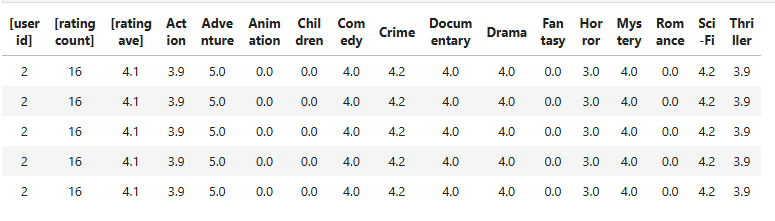

In [84]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)

[movie id],year,ave rating,Act ion,Adve nture,Anim ation,Chil dren,Com edy,Crime,Docum entary,Drama,Fan tasy,Hor ror,Mys tery,Rom ance,Sci -Fi,Thri ller
6874,2003,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6874,2003,4.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6874,2003,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8798,2004,3.8,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8798,2004,3.8,0,0,0,0,0,1,0,0,0,0,0,0,0,0


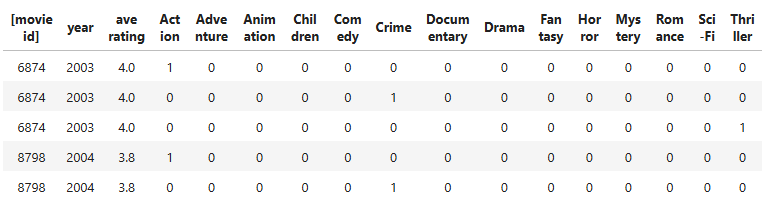

In [85]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [4.  4.  4.  3.5 3.5]


In [86]:
if scaledata:
    item_train_save = item_train
    user_train_save = user_train

    scalerItem = StandardScaler()
    scalerItem.fit(item_train)
    item_train = scalerItem.transform(item_train)

    scalerUser = StandardScaler()
    scalerUser.fit(user_train)
    user_train = scalerUser.transform(user_train)

    print(np.allclose(item_train_save, scalerItem.inverse_transform(item_train)))
    print(np.allclose(user_train_save, scalerUser.inverse_transform(user_train)))

True
True


In [87]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test  data shape: {item_test.shape}")


movie/item training data shape: (46549, 17)
movie/item test  data shape: (11638, 17)


In [88]:
scaler = MinMaxScaler((-1, 1))
scaler.fit(y_train.reshape(-1, 1))
ynorm_train = scaler.transform(y_train.reshape(-1, 1))
ynorm_test = scaler.transform(y_test.reshape(-1, 1))
print(ynorm_train.shape, ynorm_test.shape)

(46549, 1) (11638, 1)


##Neural Network for content based filtering

In [89]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),
    ### END CODE HERE ###
])

item_NN = tf.keras.models.Sequential([
    ### START CODE HERE ###
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),
    ### END CODE HERE ###
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features,))
vu = user_NN(input_user)
vu = keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vu)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features,))
vm = item_NN(input_item)
vm = keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vm)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = Model([input_user, input_item], output)

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_38      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_42       │ (None, 32)        │     40,864 │ input_layer_36[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_43       │ (None, 32)        │     41,376 │ input_layer_38[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 32)        │          0 │ sequential_42[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 32)        │          0 │ sequential_43[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_2 (Dot)         │ (None, 1)         │          0 │ lambda_5[0][0],   │
│                     │                   │            │ lambda_6[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 82,240 (321.25 KB)

 Trainable params: 82,240 (321.25 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [91]:
tf.random.set_seed(1)
model.fit([user_train[:, u_s:], item_train[:, i_s:]], ynorm_train, epochs=30)

Epoch 1/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.1300
Epoch 2/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1172
Epoch 3/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.1150
Epoch 4/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1138
Epoch 5/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.1128
Epoch 6/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.1118
Epoch 7/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.1108
Epoch 8/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1101
Epoch 9/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1094
Epoch 10/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1087
Epoch 11/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1077
Epoch 12/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.1066
Epoch 13/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1056
Epoch 14/30
1455/1455 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1049
Epoch 15/30
1455/145

In [92]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], ynorm_test)

364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1063


0.10686907917261124

##Predictions for new user

In [93]:
new_user_id = 5000
new_rating_ave = 1.0
new_action = 1.0
new_adventure = 1
new_animation = 1
new_childrens = 1
new_comedy = 5
new_crime = 1
new_documentary = 1
new_drama = 1
new_fantasy = 1
new_horror = 1
new_mystery = 1
new_romance = 5
new_scifi = 5
new_thriller = 1
new_rating_count = 3

user_vec = np.array([[new_user_id, new_rating_count, new_rating_ave,
                      new_action, new_adventure, new_animation, new_childrens,
                      new_comedy, new_crime, new_documentary,
                      new_drama, new_fantasy, new_horror, new_mystery,
                      new_romance, new_scifi, new_thriller]])

In [94]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale the vectors and make predictions for all movies. Return results sorted by rating.
sorted_index, sorted_ypu, sorted_items, sorted_user = predict_uservec(user_vecs,  item_vecs, model, u_s, i_s,
                                                                       scaler, scalerUser, scalerItem, scaledata=scaledata)

print_pred_movies(sorted_ypu, sorted_user, sorted_items, movie_dict, maxcount = 10)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


y_p,movie id,rating ave,title,genres
4.75026,89864,3.63158,50/50 (2011),Comedy|Drama
4.74848,76251,3.65116,Kick-Ass (2010),Action|Comedy
4.73877,69122,3.63158,"Hangover, The (2009)",Comedy|Crime
4.73181,69784,3.65,Brüno (Bruno) (2009),Comedy
4.72223,117590,3.63636,Horrible Bosses 2 (2014),Comedy|Crime
4.71803,69757,3.66667,(500) Days of Summer (2009),Comedy|Drama|Romance
4.71803,70183,3.66667,"Ugly Truth, The (2009)",Comedy|Drama|Romance
4.71345,112138,3.68421,22 Jump Street (2014),Action|Comedy|Crime
4.70894,79091,3.68421,Despicable Me (2010),Animation|Children|Comedy|Crime
4.70452,63131,3.625,Role Models (2008),Comedy


In [97]:
uid =  36
# form a set of user vectors. This is the same vector, transformed and repeated.
user_vecs, y_vecs = get_user_vecs(uid, scalerUser.inverse_transform(user_train), item_vecs, user_to_genre)

# scale the vectors and make predictions for all movies. Return results sorted by rating.
sorted_index, sorted_ypu, sorted_items, sorted_user = predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scaler,
                                                                      scalerUser, scalerItem, scaledata=scaledata)
sorted_y = y_vecs[sorted_index]

#print sorted predictions
print_existing_user(sorted_ypu, sorted_y.reshape(-1,1), sorted_user, sorted_items, item_features, ivs, uvs, movie_dict, maxcount = 10)

I am here
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


y_p,y,user,user genre ave,movie rating ave,title,genres
3.0,3.0,36,3.00,2.86,"Time Machine, The (2002)",Adventure
2.8,3.0,36,3.00,2.86,"Time Machine, The (2002)",Sci-Fi
2.8,3.0,36,3.00,2.86,"Time Machine, The (2002)",Action
2.0,1.5,36,1.75,3.52,Road to Perdition (2002),Crime
2.0,2.0,36,1.75,3.52,Gangs of New York (2002),Crime
2.0,1.0,36,1.50,4.00,"Beautiful Mind, A (2001)",Drama
1.8,1.0,36,1.00,4.00,"Beautiful Mind, A (2001)",Romance
1.7,1.5,36,1.50,3.52,Road to Perdition (2002),Drama
1.7,2.0,36,1.50,3.52,Gangs of New York (2002),Drama




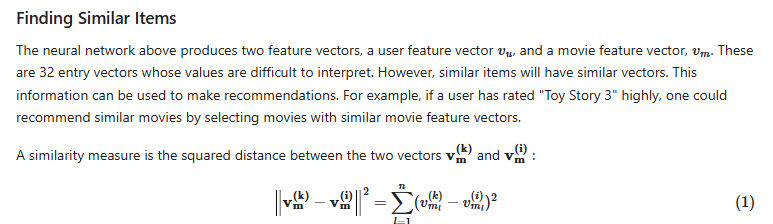



In [98]:
def sq_dist(a,b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """
    ### START CODE HERE ###
    d = sum(np.square(a-b))
    ### END CODE HERE ###
    return (d)

In [99]:
a1 = np.array([1.0, 2.0, 3.0]); b1 = np.array([1.0, 2.0, 3.0])
a2 = np.array([1.1, 2.1, 3.1]); b2 = np.array([1.0, 2.0, 3.0])
a3 = np.array([0, 1, 0]);       b3 = np.array([1, 0, 0])
print(f"squared distance between a1 and b1: {sq_dist(a1, b1)}")
print(f"squared distance between a2 and b2: {sq_dist(a2, b2)}")
print(f"squared distance between a3 and b3: {sq_dist(a3, b3)}")

squared distance between a1 and b1: 0.0
squared distance between a2 and b2: 0.030000000000000054
squared distance between a3 and b3: 2


In [104]:
input_item_m = tf.keras.layers.Input(shape=(num_item_features,1))    # input layer
vm_m = item_NN(input_item_m)                                       # use the trained item_NN
vm_m = keras.layers.Lambda(lambda x: tf.linalg.l2_normalize(x, axis=1))(vm_m) # incorporate normalization as was done in the original model
model_m = Model(input_item_m, vm_m)
model_m.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)     │ (None, 16, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_43 (Sequential)      │ (None, 16, 32)         │        41,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 16, 32)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,376 (161.62 KB)

 Trainable params: 41,376 (161.62 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
scaled_item_vecs = scalerItem.transform(item_vecs)
vms = model_m.predict(scaled_item_vecs[:,i_s:])
print(f"size of all predicted movie feature vectors: {vms.shape}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
size of all predicted movie feature vectors: (1883, 32)


In [106]:
count = 50
dim = len(vms)
dist = np.zeros((dim,dim))

for i in range(dim):
    for j in range(dim):
        dist[i,j] = sq_dist(vms[i, :], vms[j, :])

m_dist = ma.masked_array(dist, mask=np.identity(dist.shape[0]))  # mask the diagonal

disp = [["movie1", "genres", "movie2", "genres"]]
for i in range(count):
    min_idx = np.argmin(m_dist[i])
    movie1_id = int(item_vecs[i,0])
    movie2_id = int(item_vecs[min_idx,0])
    genre1,_  = get_item_genre(item_vecs[i,:], ivs, item_features)
    genre2,_  = get_item_genre(item_vecs[min_idx,:], ivs, item_features)

    disp.append( [movie_dict[movie1_id]['title'], genre1,
                  movie_dict[movie2_id]['title'], genre2]
               )
table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".2f"])
table

movie1,genres,movie2,genres
Save the Last Dance (2001),Drama,John Q (2002),Drama
Save the Last Dance (2001),Romance,"Sweetest Thing, The (2002)",Romance
"Wedding Planner, The (2001)",Comedy,Spy Kids (2001),Comedy
"Wedding Planner, The (2001)",Romance,Mr. Deeds (2002),Romance
Hannibal (2001),Horror,"Mothman Prophecies, The (2002)",Horror
Hannibal (2001),Thriller,Panic Room (2002),Thriller
Saving Silverman (Evil Woman) (2001),Comedy,Cats & Dogs (2001),Comedy
Saving Silverman (Evil Woman) (2001),Romance,Mona Lisa Smile (2003),Romance
Down to Earth (2001),Comedy,Joe Dirt (2001),Comedy
Down to Earth (2001),Fantasy,"Haunted Mansion, The (2003)",Fantasy


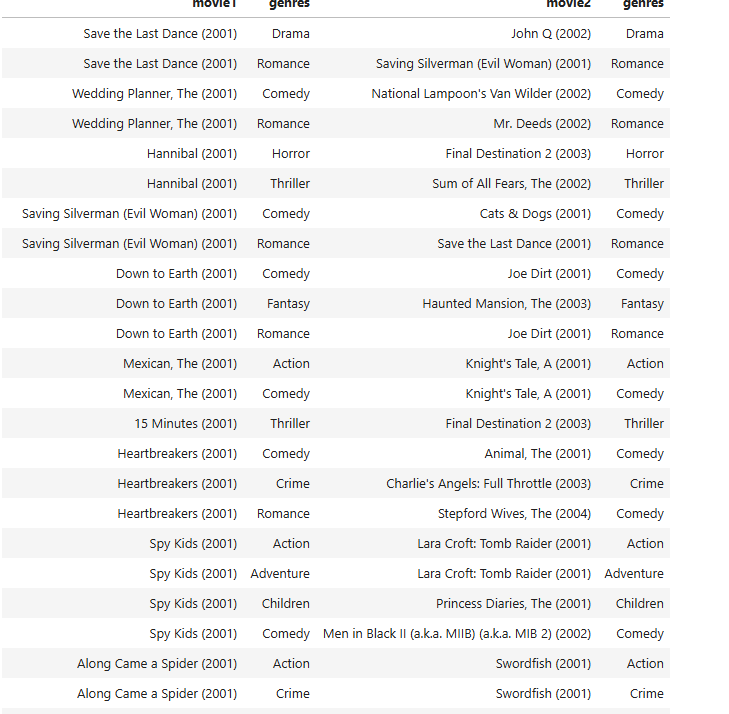